Credit: Code and references for this program are directly taken from/inspired by pages from the textbook "Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems by Aurelien Geron", second edition AND third edition

In [38]:
# Fetch data to be used for ML Prediction Model development

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def loadHousingData():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [39]:
housing = loadHousingData()
# Look at the first few rows of data to get an idea of the structure
housing.head()

C:\Users\Chloe Wei\AppData\Local\Temp\ipykernel_289760\3526692123.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# Get quick description of data (i.e. num of rows, type of each attribute, etc.)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# See the different categories and count how many districts fall into each category for the ocean_proximity categorical attribute
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

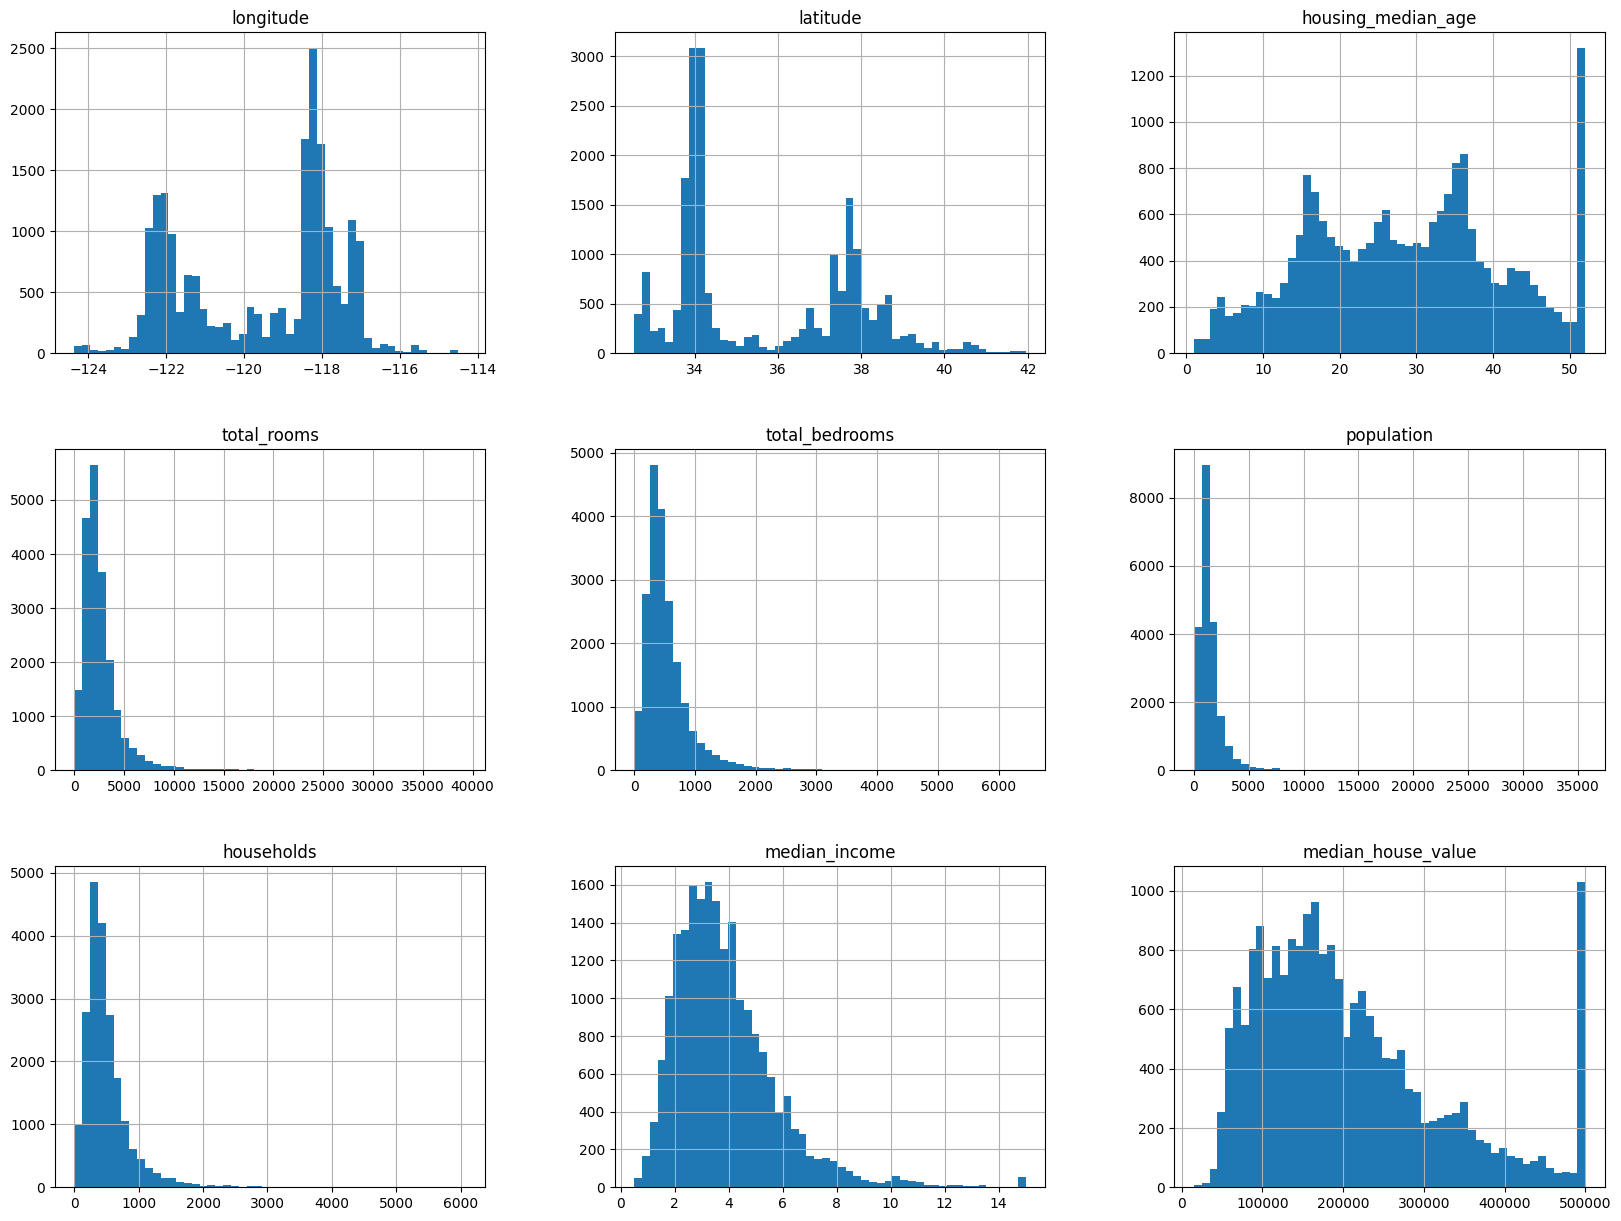

In [5]:
# Histogram of each features
%matplotlib inline

import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

Diagrams demonstrating the count for different attributes as provided in the dataset. There seems to be a tail-heavy distribution for some of the attributes (or a spike towards larger values).

Note that median income is scaled; 1 represents 10, 000 and so on and so forth

In [6]:
# Function to create test set and training set by splitting provided data by user-provided ratio
import numpy as np
def split_train_test(data, test_ratio):
    # Shuffle data to maximize chances of getting truly random sample of data
    shuffled_indices = np.random.permutation(len(data))
    # Set desired size of the test data
    test_set_size = int(len(data) * test_ratio)
    # Split given data into test and training data via indices
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
# Split data into testing and training data
train_set, test_set = split_train_test(housing, 0.2)

In [8]:
# Alternative way to split data set into training and test data via built-in function
# Identical to function above except also allows you to set a random generator seed to ensure the data is split the same way every time it is run
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Mimicked scenario: Told that median income is an important indicator of median housing price. Then accordingly use stratified sampling to make sure that the test set is representative of the income categories of people in the entire dataset to properly see how accurate trained model is:

<Axes: >

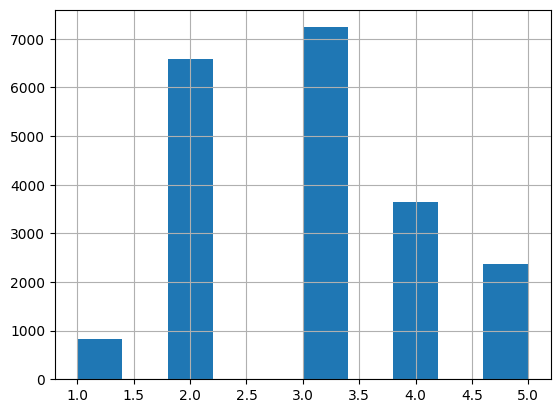

In [9]:
# Split full data set into 5 income category intervals to see spread of median income
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Display results in histogram
housing["income_cat"].hist()

<Axes: >

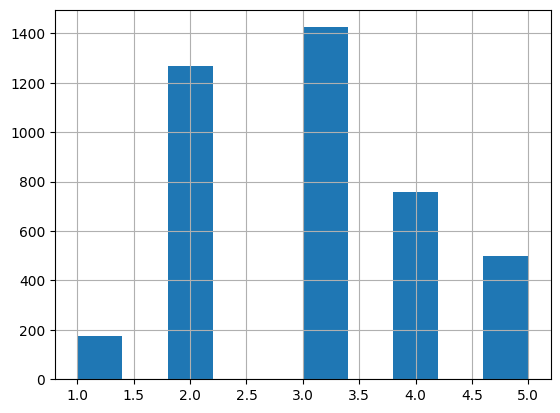

In [10]:
# Split test data set into 5 income category intervals to see spread of median income
test_set["income_cat"] = pd.cut(test_set["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Display results in histogram
test_set["income_cat"].hist()

In [11]:
# Use SK-learn's built-in Stratified ShuffleSplit class to do the stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [12]:
# See if stratified sampling works by comparing if it produces a test set with median income proportions closer to the actual full dataset median income proportions than with a random sampling test dataset
# Stratified sampling
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [13]:
# All data
housing["income_cat"].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

In [14]:
# Random sampling
test_set["income_cat"].value_counts() / len(housing)

income_cat
3    0.069041
2    0.061483
4    0.036822
5    0.024176
1    0.008479
Name: count, dtype: float64

Clearly, stratified sampling produces a test set with proportions most representative of those in the full data set compared to a randomly generated test set

In [15]:
# Remove the income_cat attribute from the stratified sampling training and test set so that the data can return to its original state
for set in (strat_train_set, strat_test_set):
    set.drop("income_cat", axis=1, inplace=True)

In [16]:
# Test training set based on data given to play around without worrying about harming the training set (and my flowers)
# Create copy of data set so can play around it as many times as you ant it:

housing = strat_train_set.copy()

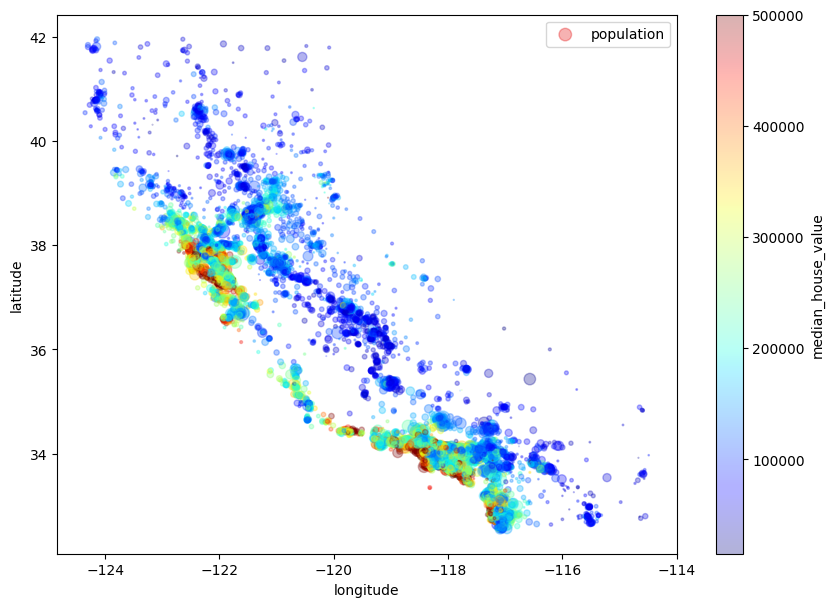

In [17]:
# Visualize the data
# Alpha param displays relative densities of points across areas in the chart
# Style plot to show characteristics and trends in data; 
# radius of circle represents associated district's population (represented by param s)
# and color represents the price of the property (blue means low price and red means high) (represented by param c)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3, s=housing["population"]/100, label="population", figsize=(10, 7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)

plt.legend()



Based on results, housing prices tend to be high along the ocean (i.e. Red prices along ocean). They also seem to be pretty high for areas with dense populations (i. e. Many areas with points with big radii tend to be more green or red, although this is not the case for all points).

In [18]:
# Assess correlation of each attribute with the median house price value via standard correlation coefficient
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Based on the coefficients, it seems that median income has a strong linear correlation with the median house value

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

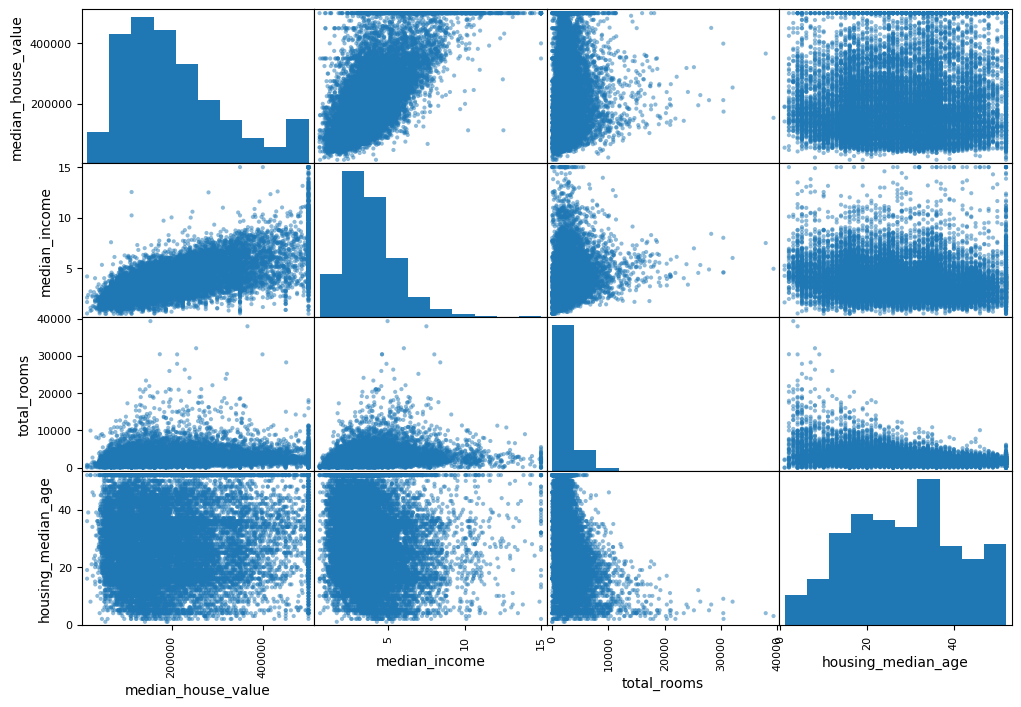

In [19]:
# Plot some attributes that seem to correlate the most with the median housing value to see their relationship
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

From the correlation coefficient and the above scatter plots, it seems like median income is the best indicator for median house value. This relationship is further examined in the scatterplot below:

<Axes: xlabel='median_income', ylabel='median_house_value'>

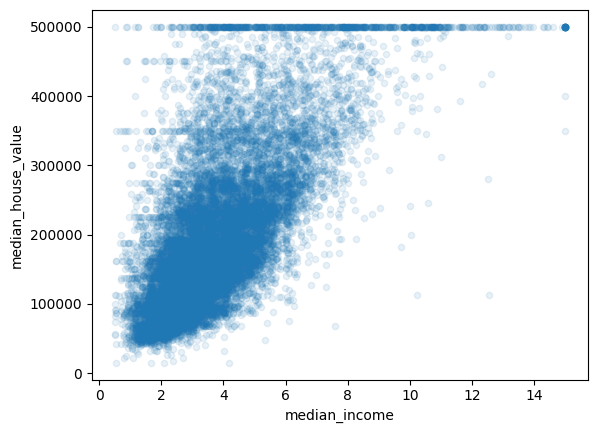

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

Observations: 
- Shape of the scatter plot reveals that correlation is indeed strong
- There seems to be outliers in the dataset as there are horizontal lines along the 500000, 460000, and 350000 median house values


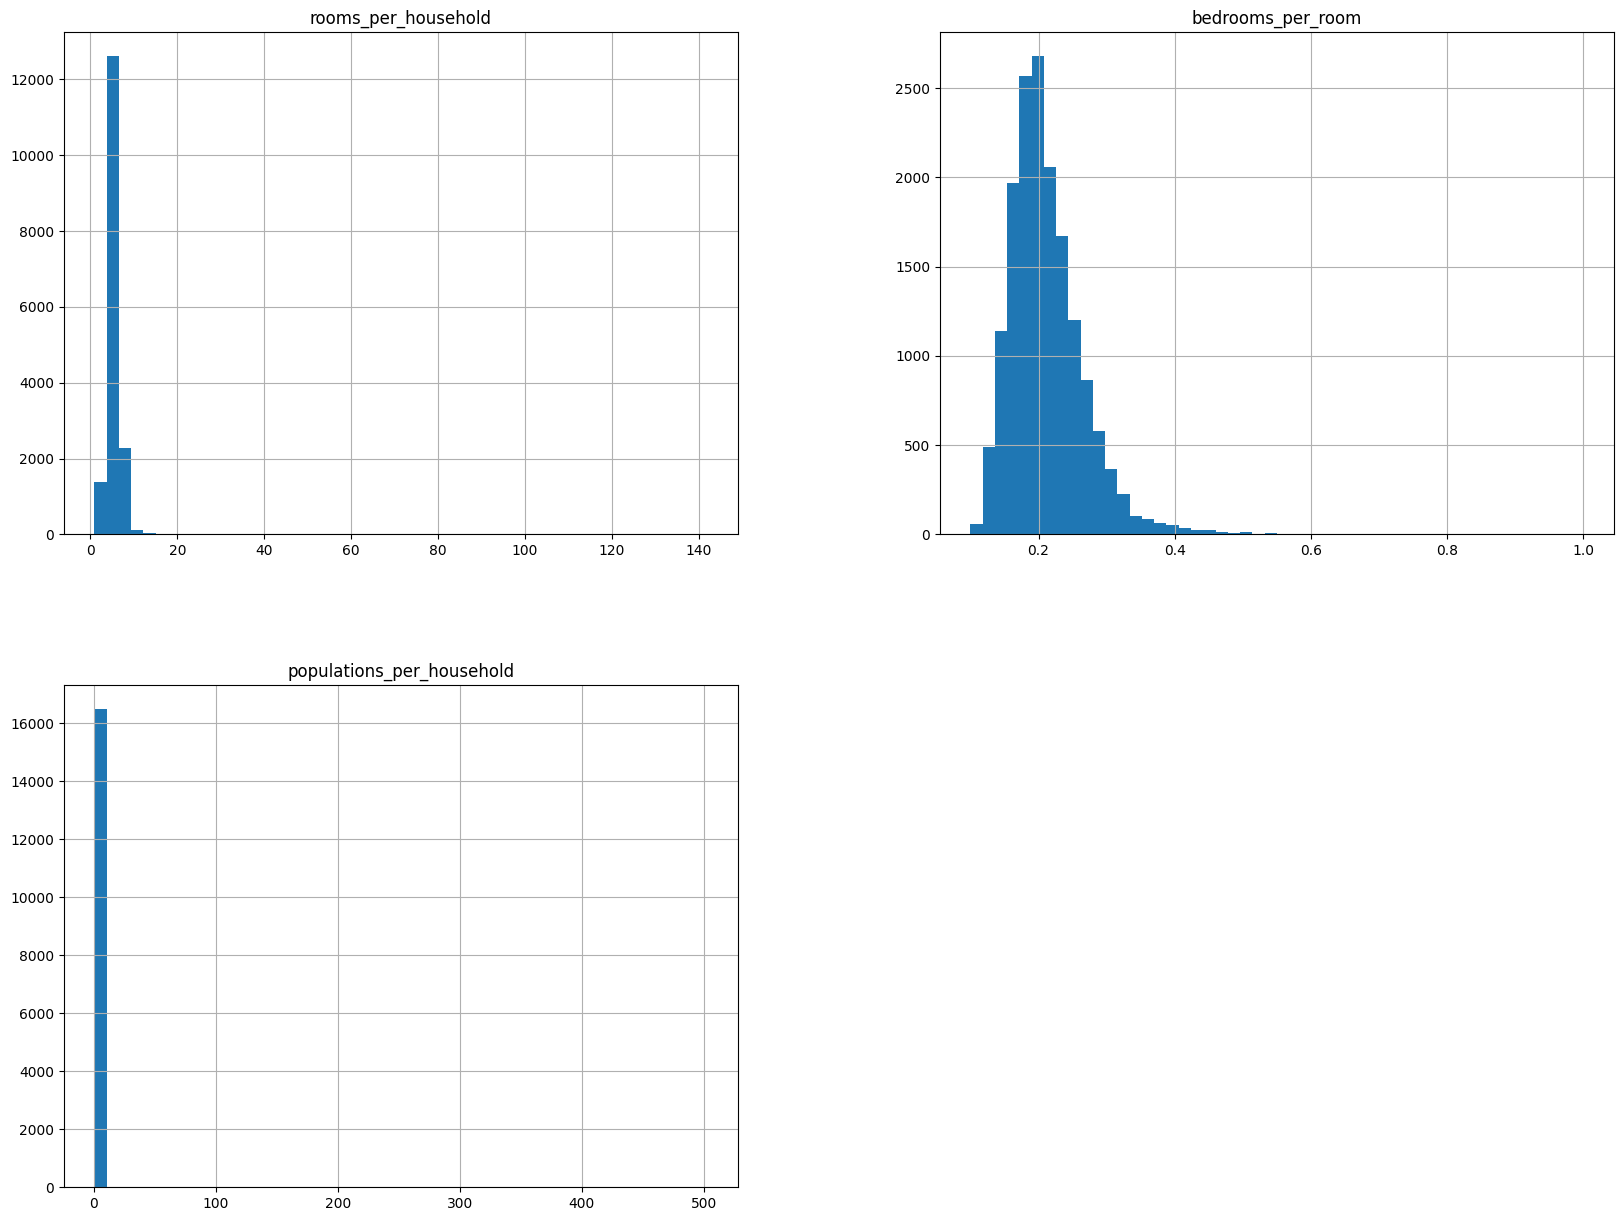

In [21]:
# Create new attributes that might be worth exploring by manipulating known attributes
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["populations_per_household"] = housing["population"]/housing["households"]

# View histograms of selected attributes
selected_attributes = ["rooms_per_household", "bedrooms_per_room", "populations_per_household"]
housing[selected_attributes].hist(bins=50, figsize=(20, 15))
plt.show()

In [22]:
# Look at correlations again, now including new attributes
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.688380
rooms_per_household          0.143663
total_rooms                  0.137455
housing_median_age           0.102175
households                   0.071426
total_bedrooms               0.054635
population                  -0.020153
populations_per_household   -0.038224
longitude                   -0.050859
latitude                    -0.139584
bedrooms_per_room           -0.256397
Name: median_house_value, dtype: float64

Now that the data has been explored, it is time to clean it and prepare it for ML algorithms:

In [23]:
# Get a clean copy of the dataset so that the cleaning and preprocessing is done effectively

# Drop the median_house_value attribute since that is the target value we are trying to get (which we don't necessarily want to be transformed along with the other predictors)
housing = strat_train_set.drop("median_house_value", axis=1)
# Make a copy of the target values for the training set
housing_labels = strat_train_set["median_house_value"].copy()

In [24]:
# As seen earlier, some of the data entries are missing some values (ex. a total_bedrooms attribute value)
# For these entries, fill them with the median of the value
# Will use sci-kit learn SimpleImputer to take care of these missing values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [25]:
# Since median can only be computed on numerical attributes and ocean_proximity attribute is non-numerical, 
# must create a copy of housing dataset with ocean_proximity attribute removed so median can be calculated
housing_numerical = housing.drop("ocean_proximity", axis=1)

# Fit imputer instance to training data
imputer.fit(housing_numerical)

# Check accuracy of imputer by comparing with calculated median values for housing_numerical attributes
imputer.statistics_
housing_numerical.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [27]:
# Use "trained" imputer to transform training set by replacing missing values with learned median from simple imputer
newDataset = imputer.transform(housing_numerical)


# Transform new dataset with median added into pandas dataframe
housing_tr = pd.DataFrame(newDataset, columns=housing_numerical.columns, index=housing_numerical.index)

Handle the categorical attributes (ex. ocean_proximity attribute):

In [28]:
# Pull out the ocean_proximity attribute data for investigation
housing_categorical_data = housing[["ocean_proximity"]]
# Look at first 10 values
housing_categorical_data.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [29]:
# Convert categorical attribute into numbers (because many ML algorithms prefer to work with numbers)
from sklearn.preprocessing import OrdinalEncoder

# Transform categorical data into numerical data
ordinal_encoder = OrdinalEncoder()
housing_categorical_encoded = ordinal_encoder.fit_transform(housing_categorical_data)

# Take a peek at first 10 new transformed values
housing_categorical_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

In [30]:
# Take a look at categories in ocean_proximity attrbiute
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [32]:
# Note that ML algorithms automatically assume that 2 categories that are closer to each other are more similar than two distant categories, 
# which isn't true in the case of ocean proximities (ex. <1H OCEAN is more closely related to NEAR OCEAN than it is to INLAND)
# Fix this via one-hot encoding

from sklearn.preprocessing import OneHotEncoder
categorical_encoder = OneHotEncoder()
housing_categorical_1hot = categorical_encoder.fit_transform(housing_categorical_data)

# Check that the one-hot encoded ocean_proximity value for each data entry is stored as a sparse matrix 
# (as it saves memory by only storing location of nonzero elements)
housing_categorical_1hot


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [ ]:
# Custom transformer class that adds in combined attributes (bedrooms per room (optionally), rooms per household and population per household)

from sklearn.base import BaseEstimator, TransformerMixin
